# Importación de dependencias y lectura de datasets.

In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import joblib 
data = pd.read_csv('final_data_spanish.csv')
# Cargar el dataset

# Verificar las primeras filas para asegurarnos de que se carga correctamente
print("Primeras filas del dataset:")
print(data.head())


Primeras filas del dataset:
   Unnamed: 0           EventName  RoundNumber  eventYear               Team  \
0        3830  Spanish Grand Prix            4       2021  Alfa Romeo Racing   
1        3831  Spanish Grand Prix            4       2021  Alfa Romeo Racing   
2        3832  Spanish Grand Prix            4       2021  Alfa Romeo Racing   
3        3833  Spanish Grand Prix            4       2021  Alfa Romeo Racing   
4        3834  Spanish Grand Prix            4       2021  Alfa Romeo Racing   

  Compound Driver  Stint  bestPreRaceTime bestLapTimeIsFrom  ...  \
0   MEDIUM    GIO    2.0           78.356        Qualifying  ...   
1   MEDIUM    RAI    1.0           78.917        Qualifying  ...   
2     SOFT    GIO    1.0           78.356        Qualifying  ...   
3     SOFT    GIO    3.0           78.356        Qualifying  ...   
4     SOFT    RAI    2.0           78.917        Qualifying  ...   

   lapNumberAtBeginingOfStint  StintLen  CircuitLength  designedLaps  \
0         

# Definición de variables de entrada y salida

In [99]:

# Agrupar por Driver y Año
grouped = data.groupby(['Driver', 'eventYear','EventName'])

def extract_strategy(group):
    # Ordenar por lapNumberAtBeginingOfStint
    group_sorted = group.sort_values('lapNumberAtBeginingOfStint')
    
    # Número de paradas es el número de stints menos 1
    num_stops = len(group_sorted) - 1
    
    circuit_length = group_sorted.iloc[0]['CircuitLength']
    start_position = group_sorted.iloc[0]['GridPosition']
    end_position = group_sorted.iloc[0]['Position']
    designed_laps = group_sorted.iloc[0]['designedLaps']
    
    if num_stops > 3:
        num_stops = 3

    # Obtener el neumático inicial
    initial_tire = group_sorted.iloc[0]['Compound']
    
    # Inicializar listas
    lap_stops = []
    tire_types = []
    temp_evolution = []
    rainfall_evolution = []
    deg_slope = []
    
    # Iterar sobre las paradas (excepto el primer stint)
    for i in range(1, len(group_sorted)):
        lap_stops.append(group_sorted.iloc[i]['lapNumberAtBeginingOfStint'])
        tire_types.append(group_sorted.iloc[i]['Compound'])
        temp_evolution.append(group_sorted.iloc[i]['meanTrackTemp'])
        rainfall_evolution.append(group_sorted.iloc[i]['Rainfall'])
        deg_slope.append(group_sorted.iloc[i]['deg_slope'])
    
    # Si hay menos de 3 paradas, rellenar con NaN o un valor predeterminado
    while len(lap_stops) < 3:
        lap_stops.append(np.nan)
        temp_evolution.append(np.nan)
        rainfall_evolution.append(np.nan)
        deg_slope.append(np.nan)
        tire_types.append('None')  # Suponiendo que 'None' representa ausencia de neumático

    
    # Si hay más de 3 paradas, truncar la lista
    lap_stops = lap_stops[:3]
    tire_types = tire_types[:3]
    temp_evolution = temp_evolution[:3]
    rainfall_evolution = rainfall_evolution[:3]
    deg_slope = deg_slope[:3]

    return pd.Series({
        'num_stops': num_stops,
        'start_position' :  start_position,
        'end_position' : end_position,
        'circuitLength' : circuit_length,
        'designedLaps' : designed_laps,
        'lap_stop_1': lap_stops[0],
        'lap_stop_2': lap_stops[1],
        #'lap_stop_3': lap_stops[2],
        'tire_type_0' : initial_tire,
        'tire_type_1': tire_types[0],
        'tire_type_2': tire_types[1],
        #'tire_type_3': tire_types[2],
        'deg_slope_1': deg_slope[0],
        'deg_slope_2': deg_slope[1],
        #'deg_slope_3': deg_slope[2],
        'temp_1': temp_evolution[0],
        'temp_2': temp_evolution[1],
        #'temp_3': temp_evolution[2],
        'rainfall_1' : rainfall_evolution[0],
        'rainfall_2' : rainfall_evolution[1],
        #'rainfall_3' : rainfall_evolution[2]
    })

# Aplicar la función a cada grupo
strategies = grouped.apply(extract_strategy).reset_index()

print("Estrategias extraídas:")
print (strategies.head)

Estrategias extraídas:
<bound method NDFrame.head of    Driver  eventYear           EventName  num_stops  start_position  \
0     ALB       2019  Spanish Grand Prix          2            11.0   
1     ALB       2020  Spanish Grand Prix          2             6.0   
2     ALB       2022  Spanish Grand Prix          3            18.0   
3     ALO       2018  Spanish Grand Prix          1             8.0   
4     ALO       2021  Spanish Grand Prix          2            10.0   
..    ...        ...                 ...        ...             ...   
95    VET       2019  Spanish Grand Prix          2             3.0   
96    VET       2020  Spanish Grand Prix          1            11.0   
97    VET       2021  Spanish Grand Prix          2            13.0   
98    VET       2022  Spanish Grand Prix          2            16.0   
99    ZHO       2022  Spanish Grand Prix          1            15.0   

    end_position  circuitLength  designedLaps  lap_stop_1  lap_stop_2  \
0           11.0     

C:\Users\naxo_\AppData\Local\Temp\ipykernel_16704\1369643867.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strategies = grouped.apply(extract_strategy).reset_index()


# EDA

In [100]:
# Reemplazar 'None' en tire_types con categoría UNKNOWN
strategies[['tire_type_0', 'tire_type_1', 'tire_type_2']] = strategies[['tire_type_0', 'tire_type_1', 'tire_type_2']].fillna('UNKNOWN')

print("Estrategias después de manejar valores faltantes:")
print(strategies.head())

Estrategias después de manejar valores faltantes:
  Driver  eventYear           EventName  num_stops  start_position  \
0    ALB       2019  Spanish Grand Prix          2            11.0   
1    ALB       2020  Spanish Grand Prix          2             6.0   
2    ALB       2022  Spanish Grand Prix          3            18.0   
3    ALO       2018  Spanish Grand Prix          1             8.0   
4    ALO       2021  Spanish Grand Prix          2            10.0   

   end_position  circuitLength  designedLaps  lap_stop_1  lap_stop_2  \
0          11.0          4.655            66        26.0        46.0   
1           8.0          4.655            66        18.0        40.0   
2          18.0          4.655            66        12.0        26.0   
3           8.0          4.655            66        22.0         NaN   
4          17.0          4.655            66        22.0        62.0   

  tire_type_0 tire_type_1 tire_type_2  deg_slope_1  deg_slope_2     temp_1  \
0        SOFT     

In [101]:
# Identificar columnas categóricas
categorical_cols = ['EventName','tire_type_0','tire_type_1','tire_type_2']

# Inicializar el codificador
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Ajustar y transformar las columnas categóricas
encoded_tires = encoder.fit_transform(strategies[categorical_cols])

print("Forma de las variables categóricas codificadas:", encoded_tires.shape)
print("Ejemplo de codificación de neumáticos:")
print(encoded_tires[0])

# Escalado de variables continuas
continuous_cols = ['num_stops','designedLaps','circuitLength','lap_stop_1','lap_stop_2', 'temp_1', 'temp_2', 'rainfall_1', 'rainfall_2']

for x in continuous_cols:
    mean_of_column = strategies[x].mean()
    strategies[x].fillna(mean_of_column, inplace = True)
strategies 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_continuous = scaler.fit_transform(strategies[continuous_cols])

print("Forma de las variables continuas escaladas:", scaled_continuous.shape)
print("Ejemplo de variables continuas escaladas:")
print(scaled_continuous[0])



# Combinar las variables continuas y categóricas
processed_data = np.hstack((scaled_continuous, encoded_tires))

print("Forma del conjunto de datos procesado:", processed_data.shape)
print("Ejemplo de estrategia procesada:")
print(processed_data[0])

# Guardar el codificador y el escalador
joblib.dump(encoder, 'tire_encoder.joblib')
joblib.dump(scaler, 'continuous_scaler.joblib')

print("Objetos de preprocesamiento guardados correctamente.")

Forma de las variables categóricas codificadas: (100, 14)
Ejemplo de codificación de neumáticos:
[1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Forma de las variables continuas escaladas: (100, 9)
Ejemplo de variables continuas escaladas:
[0.66666667 0.         0.         0.66666667 0.575      0.52932551
 0.50176821 0.         0.        ]
Forma del conjunto de datos procesado: (100, 23)
Ejemplo de estrategia procesada:
[0.66666667 0.         0.         0.66666667 0.575      0.52932551
 0.50176821 0.         0.         1.         0.         1.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.        ]
Objetos de preprocesamiento guardados correctamente.


C:\Users\naxo_\AppData\Local\Temp\ipykernel_16704\1594579113.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  strategies[x].fillna(mean_of_column, inplace = True)


In [5]:
print(processed_data[0])

[0.66666667 0.         0.         0.66666667 0.575      0.52932551
 0.50176821 0.         0.         1.         0.         1.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.        ]


# Arquitectura CGAN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Dropout

def build_generator(noise_dim, data_dim):
    model = Sequential()
    
    # Primera capa densa
    model.add(Dense(256, input_dim=noise_dim))
    model.add(ReLU(name = 'relu_1'))
    
    # Segunda capa densa
    model.add(Dense(512))
    model.add(ReLU(name = 'relu_2'))
    
    # Tercera capa densa
    model.add(Dense(1024))
    model.add(ReLU(name = 'relu_3'))
    
    # Capa de salida con activación sigmoid para [0,1]
    model.add(Dense(data_dim, activation='sigmoid'))
    
    # Escalar la salida a [0,100]
    #model.add(Lambda(lambda x: x * 100))
    
    return model

In [7]:
def build_discriminator(data_dim):
    model = Sequential()

    model.add(Dense(256, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  # Salida binaria
    return model

In [ ]:
# Parámetros
noise_dim = 100
data_dim = processed_data.shape[1]  # 23 en este ejemplo

# Construir y compilar el discriminador
discriminator = build_discriminator(data_dim)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0001, 0.5),
                      metrics=['accuracy'])

# Construir el generador
generator = build_generator(noise_dim, data_dim)

print("Resumen del Generador:")
generator.summary()

# Verificar el resumen del discriminador
print("\nResumen del Discriminador:")
discriminator.summary()

# Crear el modelo combinado
z = Input(shape=(noise_dim,))
generated_data = generator(z)
discriminator.trainable = False  # Congelar el discriminador durante el entrenamiento del generador
validity = discriminator(generated_data)

combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

# Verificar el resumen del generador
print("Resumen del Generador:")
generator.summary()

# Verificar el resumen del discriminador
print("\nResumen del Discriminador:")
discriminator.summary()

c:\Users\naxo_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\naxo_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Resumen del Generador:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 23)             │        23,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,327 (2.69 MB)

 Trainable params: 706,327 (2.69 MB)

 Non-trainable params: 0 (0.00 B)


Resumen del Discriminador:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,065 (2.53 MB)

 Trainable params: 664,065 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Resumen del Generador:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 23)             │        23,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,327 (2.69 MB)

 Trainable params: 706,327 (2.69 MB)

 Non-trainable params: 0 (0.00 B)


Resumen del Discriminador:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,065 (2.53 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 664,065 (2.53 MB)

# Entrenamiento del modelo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


c:\Users\naxo_\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.7114, acc.: 28.12%] [G loss: 0.6823]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

Muestras generadas:

Estrategia Generada 1:
Número de paradas: 1.547605037689209
Vuelta de parada 1: 19.13363265991211
Vuelta de parada 2: 43.95523452758789
Circuito: Spanish Grand Prix
Tipo de neumático 0: SOFT
Tipo de neumático 1: HARD
Tipo de neumático 2: None

Estrategia Generada 2:
Número de paradas: 1.2887046337127686
Vuelta de parada 1: 21.66482925415039
Vuelta de parada 2: 44.31385803222656
Circuito: Spanish Grand Prix
Tipo de neumático 0: SOFT
Tipo de neumático 1: HARD
Tipo de neumático 2: None

Estrategia Generada 3:
Número de paradas: 1.6170916557312012
Vuelta de parada 1: 18.55613136291504
Vuelta de parada 2: 43.435569763183594
Circuito: Spanish Grand Prix
Tipo de neumático 0: SUPERSOFT
Tipo de neumático 1: HARD
Tipo de neumático 2: SOFT

Estrategia Generada 4:
Número de paradas: 1.444368839263916
Vuelta de parada 1: 17.735580444335938
Vuelta de parada 2: 43.04314041137695
Circuito: Spa

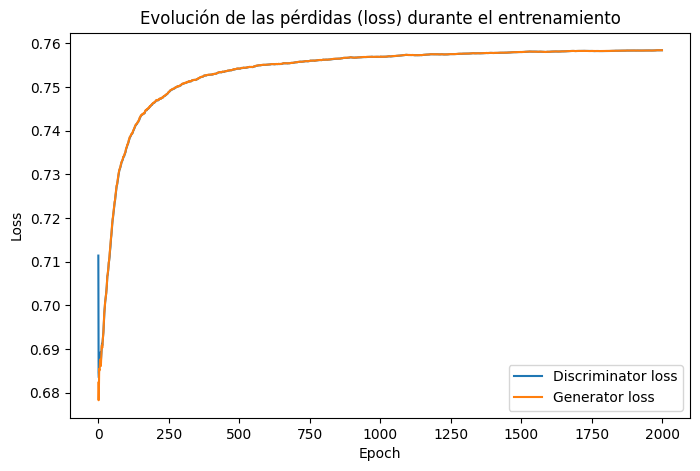

In [9]:
import matplotlib.pyplot as plt

# Parámetros de entrenamiento
epochs = 2000
batch_size = 16
sample_interval = 10

# Etiquetas
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
d_losses = []
g_losses = []
accs = []

for epoch in range(epochs):

    # Seleccionar una muestra aleatoria de datos reales
    idx = np.random.randint(0, processed_data.shape[0], batch_size)
    real_data = processed_data[idx]

    # Generar una muestra aleatoria de ruido y generar datos falsos
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    gen_data = generator.predict(noise)

    # Entrenar el discriminador
    d_loss_real = discriminator.train_on_batch(real_data, valid)
    d_loss_fake = discriminator.train_on_batch(gen_data, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generar ruido para el generador
    noise = np.random.normal(0, 1, (batch_size, noise_dim))

    # Entrenar el generador (intenta engañar al discriminador)
    g_loss = combined.train_on_batch(noise, valid)

    d_losses.append(d_loss[0])  # d_loss[0] es la pérdida
    g_losses.append(g_loss[0])
    accs.append (d_loss[1])
    # Imprimir el progreso

    print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")

    # Guardar muestras de generación
    if epoch % sample_interval == 0:
        # Generar y desescalar datos
        noise = np.random.normal(0, 1, (5, noise_dim))
        gen_samples = generator.predict(noise)

        print("\nMuestras generadas:")
        for i, sample in enumerate(gen_samples):
            print(f"\nEstrategia Generada {i+1}:")
            # Separar variables continuas y categóricas
            
            cont = sample[:9].reshape(1, -1)  # Reshape a (1, 4)
            cat = sample[9:]
            
            # Desescalar variables continuas
            descaled_cont = scaler.inverse_transform(cont)[0] 
            # Decodificar variables categóricas
            encoded_cat = cat.reshape(1, -1)
            decoded_tires = encoder.inverse_transform(encoded_cat)[0]
            
            print(f"Número de paradas: {(descaled_cont[0])}")
            print(f"Vuelta de parada 1: {(descaled_cont[3])}")
            print(f"Vuelta de parada 2: {(descaled_cont[4])}")
            print(f"Circuito: {decoded_tires[0]}")
            print(f"Tipo de neumático 0: {decoded_tires[1]}")
            print(f"Tipo de neumático 1: {decoded_tires[2]}")
            print(f"Tipo de neumático 2: {decoded_tires[3]}")

plt.figure(figsize=(8, 5))
plt.plot(d_losses, label="Discriminator loss")
plt.plot(g_losses, label="Generator loss")
plt.title("Evolución de las pérdidas (loss) durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Guardar el generador entrenado
generator.save('f1_strategy_generator.h5')
print("Generador guardado correctamente.")

import joblib

# Guardar el codificador y el escalador si no lo has hecho anteriormente
joblib.dump(encoder, 'tire_encoder.joblib')
joblib.dump(scaler, 'continuous_scaler.joblib')

print("Objetos de preprocesamiento guardados correctamente.")

from tensorflow.keras.models import load_model
import joblib
import numpy as np




Generador guardado correctamente.
Objetos de preprocesamiento guardados correctamente.
Generador cargado correctamente.
Objetos de preprocesamiento cargados correctamente.


In [43]:
# Cargar el generador entrenado
generator = load_model('f1_strategy_generator.h5')
print("Generador cargado correctamente.")

# Cargar el codificador y el escalador
encoder = joblib.load('tire_encoder.joblib')
scaler = joblib.load('continuous_scaler.joblib')
print("Objetos de preprocesamiento cargados correctamente.")

def generate_strategies(generator, encoder, scaler, num_samples=5, noise_dim=100):
    """
    Genera nuevas estrategias de pit stops utilizando el generador entrenado.

    Parámetros:
    - generator: Modelo generador entrenado.
    - encoder: Objeto OneHotEncoder guardado.
    - scaler: Objeto MinMaxScaler guardado.
    - num_samples: Número de estrategias a generar.
    - noise_dim: Dimensión del vector de ruido de entrada.

    Retorna:
    - Listado de estrategias generadas con sus detalles.
    """
    # Generar ruido aleatorio
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    
    # Generar datos falsos
    gen_data = generator.predict(noise)
    
    # Asegurar que los datos están dentro del rango [0, 100]
    gen_data = np.clip(gen_data, 0, 100)

    return gen_data

Generador cargado correctamente.
Objetos de preprocesamiento cargados correctamente.


In [102]:
# Generar 5 nuevas estrategias
nuevas_estrategias = generate_strategies(generator, encoder, scaler, num_samples=100, noise_dim=100)
estrategias_lista = []

# Presentar las estrategias generadas
for idx, estrategia in enumerate(nuevas_estrategias, start=1):

    cont = estrategia[:9].reshape(1, -1)  # Reshape a (1, 4)
    cat = estrategia[9:]

    print (cont)      
    # Desescalar variables continuas
    #descaled_cont = scaler.inverse_transform (cont)
    descaled_cont = scaler.inverse_transform(cont)[0] 
    # Decodificar variables categóricas
    encoded_cat = cat.reshape(1, -1)
    decoded_tires = encoder.inverse_transform(encoded_cat)[0]
                # Crear diccionario de la estrategia actual
    estrategia_dict = {
        "Número de paradas": descaled_cont[0],
        "Vuelta de parada 1": descaled_cont[3],
        "Vuelta de parada 2": descaled_cont[4],
        "Circuito": decoded_tires[0],
        "Tipo de neumático 0": decoded_tires[1],
        "Tipo de neumático 1": decoded_tires[2],
        "Tipo de neumático 2": decoded_tires[3],
    }
    print(f"Número de paradas: {(descaled_cont[0])}")
    print(f"Vuelta de parada 1: {(descaled_cont[3])}")
    print(f"Vuelta de parada 2: {(descaled_cont[4])}")
    print(f"Circuito: {decoded_tires[0]}")
    print(f"Tipo de neumático 0: {decoded_tires[1]}")
    print(f"Tipo de neumático 1: {decoded_tires[2]}")
    print(f"Tipo de neumático 2: {decoded_tires[3]}")

    estrategias_lista.append(estrategia_dict)

# Convertir la lista de estrategias a DataFrame de pandas
df_estrategias = pd.DataFrame(estrategias_lista)

# Exportar a CSV
df_estrategias.to_csv('estrategias_generadas.csv', index=False)

print("Estrategias guardadas en 'estrategias_generadas.csv'.")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[1.1164424e-05 6.2591016e-01 2.7727681e-05 3.0180450e-05 9.9994588e-01
  9.9993736e-01 9.9990833e-01 9.9976486e-01 9.9996752e-01]]
Número de paradas: 3.349327016621828e-05
Vuelta de parada 1: 2.001086473464966
Vuelta de parada 2: 62.99783706665039
Circuito: Spanish Grand Prix
Tipo de neumático 0: MEDIUM
Tipo de neumático 1: HARD
Tipo de neumático 2: SUPERSOFT
[[5.8709220e-06 5.7052648e-01 1.2377618e-05 1.1226349e-05 9.9995363e-01
  9.9996710e-01 9.9997193e-01 9.9993384e-01 9.9998784e-01]]
Número de paradas: 1.7612765077501535e-05
Vuelta de parada 1: 2.000404119491577
Vuelta de parada 2: 62.998146057128906
Circuito: Spanish Grand Prix
Tipo de neumático 0: MEDIUM
Tipo de neumático 1: HARD
Tipo de neumático 2: SUPERSOFT
[[8.9006835e-06 6.9975656e-01 2.4428475e-05 1.8410206e-05 9.9992275e-01
  9.9994969e-01 9.9995202e-01 9.9970460e-01 9.9995738e-01]]
Número de paradas: 2.6702051400206983e-05
Vuelta de parada 1: 2.0006628036499023
Vuelta de parada 2: 6

In [103]:
import numpy as np

def rbf_kernel(x, y, gamma=None):
    if gamma is None:
        gamma = 1.0 / x.shape[1]  # Asume que x e y son 2D
    dist_sq = np.sum((x - y)**2)
    return np.exp(-gamma * dist_sq)

def compute_mmd(X, Y, gamma=None):
    n = X.shape[0]
    m = Y.shape[0]

    # Suma de k(x, x')
    xx = 0.0
    for i in range(n):
        for j in range(n):
            xx += rbf_kernel(X[i:i+1], X[j:j+1], gamma)  # Asegura submatrices 2D
    xx /= (n * n)

    # Suma de k(y, y')
    yy = 0.0
    for i in range(m):
        for j in range(m):
            yy += rbf_kernel(Y[i:i+1], Y[j:j+1], gamma)
    yy /= (m * m)

    # Suma de k(x, y)
    xy = 0.0
    for i in range(n):
        for j in range(m):
            xy += rbf_kernel(X[i:i+1], Y[j:j+1], gamma)
    xy /= (n * m)

    mmd2 = xx + yy - 2.0 * xy
    return mmd2

def mmd_distance(real_data, gen_data, gamma=None):
    mmd2 = compute_mmd(real_data, gen_data, gamma=gamma)
    return np.sqrt(mmd2)
print("Dimensiones de processed_data:", processed_data.shape)
print("Dimensiones de nuevas_estrategias:", nuevas_estrategias.shape)
distance = mmd_distance(processed_data, nuevas_estrategias)
print("MMD distance:", distance)

import numpy as np
import ot  # 'pot' library

def wasserstein_distance(real_data, gen_data):
    """
    Calcula la distancia de Wasserstein 1D/Multidimensional 
    asumiendo la misma cantidad de muestras en real_data y gen_data
    """
    # Debes ver si tus datos son 1D, o si usan cost_matrix en alta dimensión...

    cost_matrix = ot.dist(real_data, gen_data, metric='euclidean')
    n = real_data.shape[0]
    p = np.ones((n,)) / n
    q = np.ones((n,)) / n

    # Calcula EMD: Earth Mover's Dist
    wasserstein = ot.emd2(p, q, cost_matrix)
    return wasserstein

# Ejemplo:
distance = wasserstein_distance(processed_data, nuevas_estrategias)
print("Wasserstein distance:", distance)

Dimensiones de processed_data: (100, 23)
Dimensiones de nuevas_estrategias: (100, 23)
MMD distance: 0.7948025309143639
Wasserstein distance: 3.370285436343529


In [30]:
# Generar 5 nuevas estrategias
nuevas_estrategias = generate_strategies(generator, encoder, scaler, num_samples=5, noise_dim=100)

# Presentar las estrategias generadas
for idx, estrategia in enumerate(nuevas_estrategias, start=1):
    print(f"\nEstrategia Generada {idx}:")
    print(f"Número de paradas: {estrategia['Número de paradas']}")
    print(f"Vuelta de parada 1: {estrategia['Vuelta de parada 1']}")
    print(f"Vuelta de parada 2: {estrategia['Vuelta de parada 2']}")
    print(f"Vuelta de parada 3: {estrategia['Vuelta de parada 3']}")
    print(f"Tipo de neumático 1: {estrategia['Tipo de neumático 1']}")
    print(f"Tipo de neumático 2: {estrategia['Tipo de neumático 2']}")
    print(f"Tipo de neumático 3: {estrategia['Tipo de neumático 3']}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Estrategia Generada 1:
Número de paradas: 10
Vuelta de parada 1: 61
Vuelta de parada 2: 84
Vuelta de parada 3: 32
Tipo de neumático 1: INTERMEDIATE
Tipo de neumático 2: WET
Tipo de neumático 3: WET

Estrategia Generada 2:
Número de paradas: 71
Vuelta de parada 1: 4
Vuelta de parada 2: 98
Vuelta de parada 3: 95
Tipo de neumático 1: INTERMEDIATE
Tipo de neumático 2: MEDIUM
Tipo de neumático 3: HARD

Estrategia Generada 3:
Número de paradas: 5
Vuelta de parada 1: 86
Vuelta de parada 2: 12
Vuelta de parada 3: 40
Tipo de neumático 1: MEDIUM
Tipo de neumático 2: WET
Tipo de neumático 3: SOFT

Estrategia Generada 4:
Número de paradas: 99
Vuelta de parada 1: 60
Vuelta de parada 2: 90
Vuelta de parada 3: 88
Tipo de neumático 1: ULTRASOFT
Tipo de neumático 2: HYPERSOFT
Tipo de neumático 3: HARD

Estrategia Generada 5:
Número de paradas: 6
Vuelta de parada 1: 99
Vuelta de parada 2: 0
Vuelta de parada 3: 0
Tipo de neumático 1: MEDIUM
Tipo de neumático 2: ULTR